# Self Driving Car Engineer
## Project: Behavioral Cloning
***
In this project, it is aimed to drive a car autonomously in a simulator

### Step 0: The data is loaded

In [1]:
#Importing useful libraries
import cv2 
import numpy as np
import pandas as pd

#Information of data is loaded and converted into a numpy array
data = pd.read_csv('driving_log.csv')
data = data.values

### Step 1: Defining image transformation functions

In [2]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV) #convert image into HSV format
    random_bright = 0.2 + np.random.uniform() #add some noise
    image1[:,:,2] = image1[:,:,2]*random_bright #multiply by it 
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB) #to get a different brightness
    return image1

def transform_image(img,ang_range=5.0,shear_range=0.5,trans_range=3.0):
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2 #angle value is picked from (-angle/2, angle/2)
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1) #image is rotated

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2#translation value is picked from (-trans_range/2, trans_range/2)
    tr_y = trans_range*np.random.uniform()-trans_range/2#translation value is picked from (-trans_range/2, trans_range/2)
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]]) #image is translated

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2 #shear value is picked from (5-shear_range/2, 5+shear_range/2)
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2 #shear value is picked from (20-shear_range/2, 20+shear_range/2)
    
    # Brightness 
    #Each process is applied respectively
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    img = augment_brightness_camera_images(img)
    
    return img


### Step 2: Dataset Summary

- Features are 4D array containing raw pixel data of the road images, (num examples, width, height, channels)
- Labels are 1D array containing steering angles of the car, (num_examples,)

In [27]:
center_images = []
left_images = []
right_images = []
meas_center = []
meas_left = []
meas_right = []
correction_factor = 0.45 #we add this factor to the left images and subtract it to the right images
    

for i in range(data.shape[0]):
    #Third column of data shows steering angle
    meas = float(data[i,3])
    
    #If the angle is not zero, process can start
    if meas!=0:   
        image = cv2.imread(data[i,0].strip()) #image from center camera is read
        center_images.append(image) #center images are stored in a list
        meas_center.append(meas) #steering angles are stored in a list
        
        left_img = cv2.imread(data[i,1].strip()) #image from left camera is read
        right_img = cv2.imread(data[i,2].strip()) #image from right camera is read

        left_images.append(left_img) #left images are stored in a list
        right_images.append(right_img) #right images are stored in a list

        meas_left.append(meas+correction_factor) #steering angles are stored in a list 
        meas_right.append(meas-correction_factor) #steering angles are stored in a list
        
    steer_left = meas + correction_factor
    steer_right = meas - correction_factor
    
    #To balance the dataset, additional data is added. 
    #Especially, images whose steering angles are bigger than 0.5 and smaller than -0.5 are less than rest of them
    #Therefore we augment the actual ones
    if steer_left > 0.5: #To get an image, whose steering angle is bigger than 0.5, we use left image
        left_image = cv2.imread(data[i,1].strip()) #left image is read
        left_img_aug = transform_image(left_img) #that image is augmented
        left_images.append(left_img_aug) #it is added to the list
        meas_left.append(steer_left) #steering angle is added to the list
        
    elif steer_right < -0.5: #To get an image, whose steering angle is smaller than -0.5, we use right image
        right_image = cv2.imread(data[i,2].strip()) #right image is read
        right_img_aug = transform_image(right_img) #that image is augmented
        right_images.append(right_img_aug) #it is added to the list
        meas_right.append(steer_right) #steering angle is added to the list
    
        
center_arr = np.array(center_images) #image list is converted into an array
left_arr = np.array(left_images) #image list is converted into an array
right_arr = np.array(right_images) #image list is converted into an array

meas_center_arr = np.array(meas_center) #measurement list is converted into an array
meas_left_arr = np.array(meas_left) #measurement list belongs to left images is converted into an array
meas_right_arr = np.array(meas_right) #measurement list belongs to right images is converted into an array

all_images = np.concatenate((center_images, left_arr, right_arr)) #all image arrays are concatenated
all_meas = np.concatenate((meas_center, meas_left, meas_right)) #all measurement arrays are concatenated
all_images_flip = np.fliplr(all_images) #images are flipped horizontally
all_meas_flip = -1 * all_meas #measurements are obtained for flipped images

features = np.concatenate((all_images, all_images_flip)) #images and flipped images are concatenated
labels = np.concatenate((all_meas, all_meas_flip)) #measurements and flipped measurements are concatenated

image_shape = features.shape[1:]

print ("features.shape=",features.shape)
print ("labels.shape=",labels.shape)
print ("(labels > 0).shape=",sum(labels > 0))
print ("(labels < 0).shape=",sum(labels < 0))

features.shape= (28360, 160, 320, 3)
labels.shape= (28360,)
(labels > 0).shape= 14180
(labels < 0).shape= 14180


### Step 3: Visualizing the process

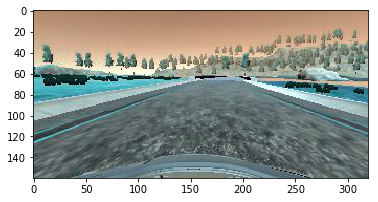

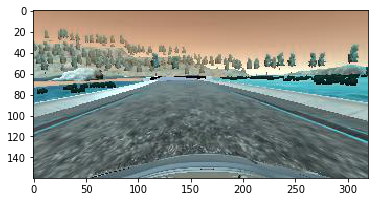

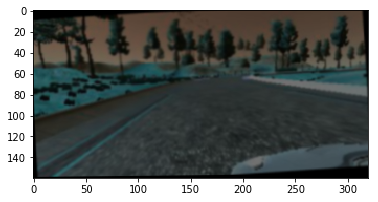

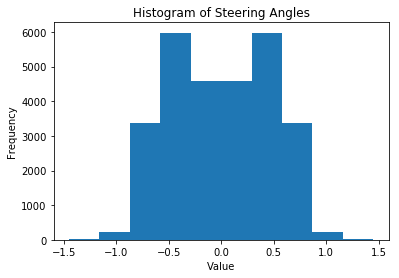

In [47]:
import matplotlib.pyplot as plt

image = features[0,:,:,:] #A sample from dataset
image_fl = np.fliplr(image) #It is flipped horizontally

plt.imshow(image) #show the original one
plt.show()

plt.imshow(image_fl) #show the flipped one
plt.show()

left_image = features[7000,:,:,:]
img_warped = transform_image(left_image) #the original image is distorted
plt.imshow(img_warped) #show the distorted one
plt.show()

plt.hist(labels)
plt.title("Histogram of Steering Angles")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Step 4: Model Architecture

In this step keeping probability for dropout method, activation function and epochs variables are defined. According to the Nvidia architecture, model is constructed. Adam optimizer is used during the training process. Mean squared error is used as loss funcion. Data is split 80%-20% training and validation respectively. In each epoch data is shuffled. At the end of it, model file is saved to test the model on the simulator

In [32]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout, BatchNormalization
from keras.optimizers import Adam

dropout_hdd = 0.5
dropout_cnv = 0.1
function = "relu"
epochs = 5

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(image_shape)))
model.add(Cropping2D(cropping=((75,20),(0,0))))
model.add(Conv2D(filters=24,kernel_size=(5,5),strides=(2, 2),activation=function))
model.add(Dropout(dropout_cnv))
model.add(Conv2D(filters=36,kernel_size=(5,5),strides=(2, 2),activation=function))
model.add(Dropout(dropout_cnv))
model.add(Conv2D(filters=48,kernel_size=(5,5),strides=(2, 2),activation=function))
model.add(Dropout(dropout_cnv))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1, 1),activation=function))
model.add(Dropout(dropout_cnv))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1, 1),activation=function))
model.add(Dropout(dropout_cnv))
model.add(Flatten())
model.add(Dense(100,activation=function))
model.add(Dropout(dropout_hdd))
model.add(Dense(50,activation=function))
model.add(Dropout(dropout_hdd))
model.add(Dense(10,activation=function))
model.add(Dropout(dropout_hdd))
model.add(Dense(1))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse',optimizer=optimizer)
model.fit(features, labels, validation_split=0.2, shuffle=True, epochs=epochs)
model.save('model.h5')

Train on 22688 samples, validate on 5672 samples
Epoch 1/5
22688/22688 [==============================] - 265s - loss: 0.1410 - val_loss: 0.3689
Epoch 2/5
22688/22688 [==============================] - 268s - loss: 0.0997 - val_loss: 0.4048
Epoch 3/5
22688/22688 [==============================] - 351s - loss: 0.0931 - val_loss: 0.4343
Epoch 4/5
22688/22688 [==============================] - 367s - loss: 0.0885 - val_loss: 0.3430
Epoch 5/5
22688/22688 [==============================] - 335s - loss: 0.0875 - val_loss: 0.3696


In [30]:
#This part is used to create files of features and labels
import pickle
from math import ceil
    
batch_size = 10000
Length = features.shape[0]
N = ceil(Length/batch_size)

for i in range(N):
    start = i*batch_size
    end = (i+1) * batch_size
    if end > Length:
        end = Length - 1
    file_name = "train_var_" + str(i+1) + ".pkl"
    with open(file_name, 'wb') as file:
        pickle.dump((features[start:end], labels[start:end]), file, protocol=pickle.HIGHEST_PROTOCOL)
    print (start,"-",end)

0 - 10000
10000 - 20000
20000 - 28359
